## FAILURE CASES

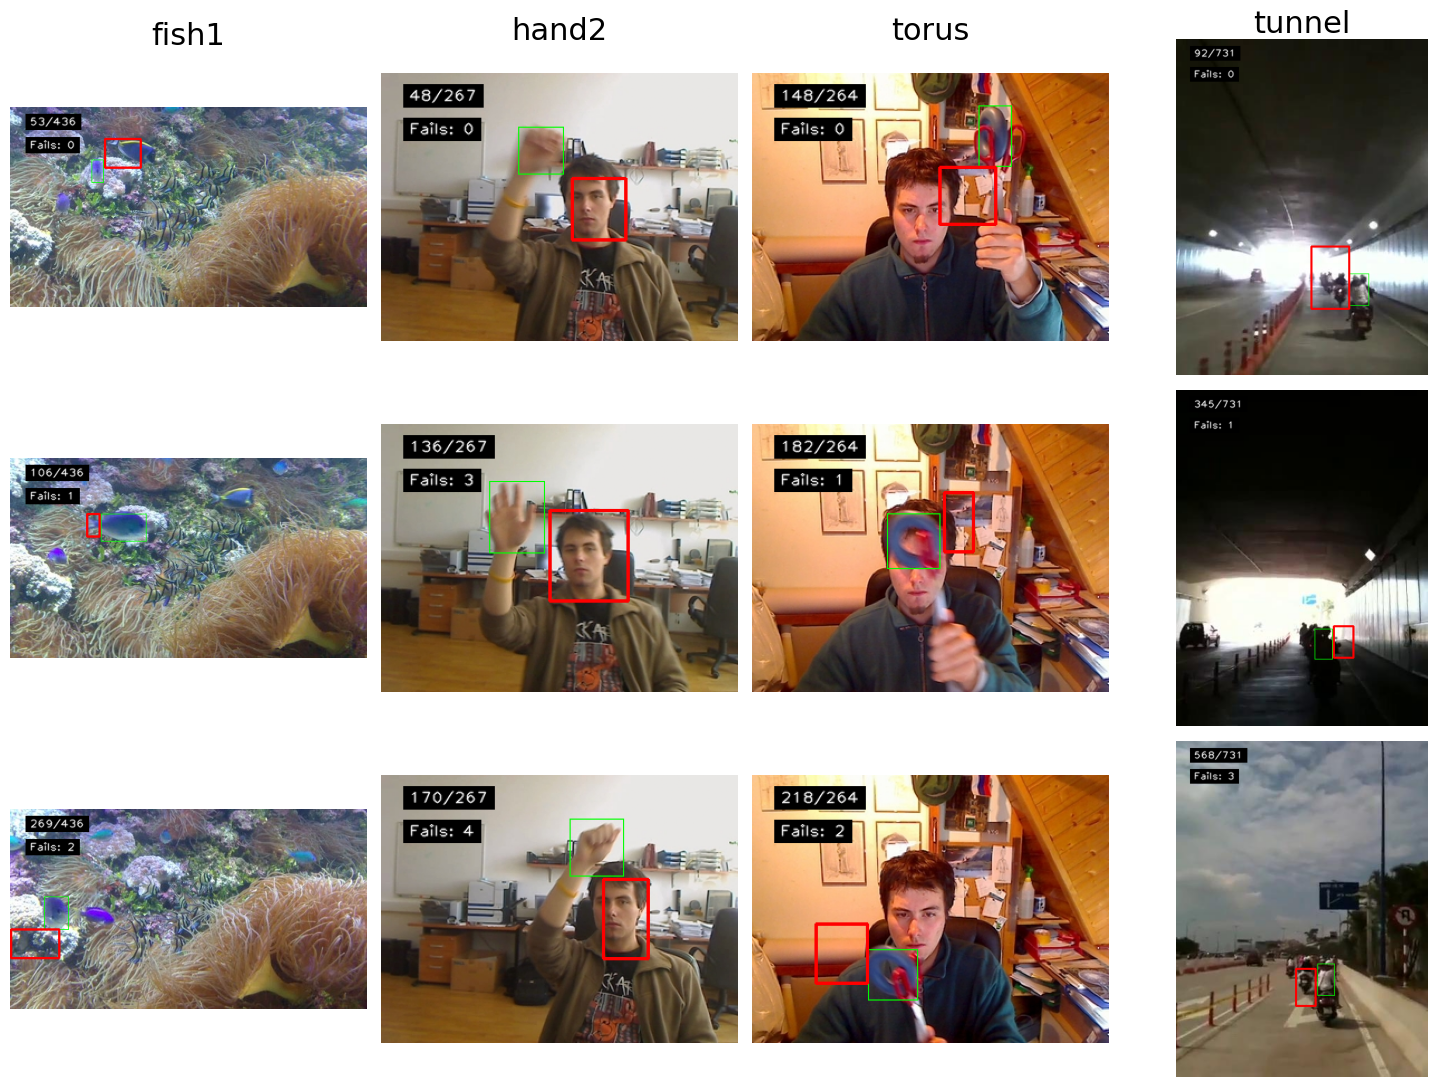

In [1]:
# colllage of failures
import matplotlib.pyplot as plt
import os 
failures_path = "failures/"
filenames = os.listdir(failures_path)
fig,axes = plt.subplots(3,4, figsize = (15,11))

# Iterate over filenames and plot images in a column-wise manner
for i, filename in enumerate(filenames):
    row_idx = i % 3  # Determines the row index (0, 1, 2)
    col_idx = i // 3  # Determines the column index (0, 1, 2, 3)

    img_path = os.path.join(failures_path, filename)
    img = plt.imread(img_path)  # Read the image

    # Plot the image at the correct axis
    axes[row_idx, col_idx].imshow(img)
    axes[row_idx, col_idx].axis('off')  # Hide axes

# Adding titles with customization
titles = ["fish1", "hand2", "torus", "tunnel"]
for col, title, pad in zip(axes[0, :], titles, [45,25,25,5]):
    col.set_title(title, fontsize=22, color='black', pad=pad)
plt.tight_layout()
plt.savefig("report/figures/failures.png")


## PARAMETER TUNING

In [2]:
import time
import os
import cv2
import pandas as pd

from sequence_utils import VOTSequence
from ms_tracker import MeanShiftTracker, MSParams

In [5]:
# set the path to directory where you have the sequences
dataset_path = 'C:\\Users\\marko\\Desktop\\Computer_vision\\Advanced-methods-in-computer-vision-assignments\\Mean-Shift-tracking\\vot2014' 
filenames = os.listdir(dataset_path)
filenames.remove("list.txt")
df = pd.DataFrame(columns=["nbins", "sigma", "n_iters", "alpha", "failures", "fps"])

total_errors = 0
# Try all possible combinations
for nbins in [4,8,16,32]:
    for sigma in [0.1,0.5, 1,2,3]:
        for n_iters in [1,10,20]:
            for alpha in [0.0,0.0001, 0.001, 0.01, 0.1, 0.2]:
                total_errors = 0
                avg_fps = 0
                for sequence in filenames:
                    #print(sequence)
                    # visualization and setup parameters
                    win_name = 'Tracking window'
                    reinitialize = True
                    show_gt = False
                    video_delay = 15
                    font = cv2.FONT_HERSHEY_PLAIN

                    # create sequence object
                    sequence = VOTSequence(dataset_path, sequence)
                    init_frame = 0
                    n_failures = 0
                    # create parameters and tracker objects
                    parameters = MSParams(nbins=nbins,sigma=sigma, n_iters=n_iters,alpha=alpha, background_size_ratio=-1)
                    tracker = MeanShiftTracker(parameters)

                    time_all = 0

                    # tracking loop - goes over all frames in the video sequence
                    frame_idx = 0
                    while frame_idx < sequence.length():
                        img = cv2.imread(sequence.frame(frame_idx))
                        # initialize or track
                        if frame_idx == init_frame:
                            # initialize tracker (at the beginning of the sequence or after tracking failure)
                            #print(sequence.get_annotation(frame_idx, type='rectangle'))
                            t_ = time.time()
                            tracker.initialize(img, sequence.get_annotation(frame_idx, type='rectangle'))
                            time_all += time.time() - t_
                            predicted_bbox = sequence.get_annotation(frame_idx, type='rectangle')
                        else:
                            # track on current frame - predict bounding box
                            t_ = time.time()
                            predicted_bbox = tracker.track(img)
                            time_all += time.time() - t_

                        # calculate overlap (needed to determine failure of a tracker)
                        gt_bb = sequence.get_annotation(frame_idx, type='rectangle')
                        o = sequence.overlap(predicted_bbox, gt_bb)

                        if o > 0 or not reinitialize:
                            # increase frame counter by 1
                            frame_idx += 1
                        else:
                            # increase frame counter by 5 and set re-initialization to the next frame
                            frame_idx += 5
                            init_frame = frame_idx
                            n_failures += 1

                    #print('Tracking speed: %.1f FPS' % (sequence.length() / time_all))
                    #print('Tracker failed %d times' % n_failures)
                    avg_fps += (sequence.length() / (time_all + 1e-10))
                    total_errors += n_failures
                avg_fps /=len(filenames)
                temp_df = pd.DataFrame([[nbins, sigma, n_iters, alpha, total_errors, avg_fps]], columns=["nbins", "sigma", "n_iters", "alpha", "failures", "fps"])
                df = pd.concat([df, temp_df], ignore_index=True)
                print(f"parameters, {sigma}, {alpha}, {n_iters}, {nbins}")
                print(f"Total errors on the dataset: {total_errors}, avg FPS: {avg_fps}")

df.to_csv("parameter_tuning.csv", index=False)

C:\Users\marko\AppData\Local\Temp\ipykernel_23148\763506856.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)


parameters, 0.1, 0.0, 1, 4
Total errors on the dataset: 145, avg FPS: 2822.4414344081943
parameters, 0.1, 0.0001, 1, 4
Total errors on the dataset: 150, avg FPS: 3040.6868364335446
parameters, 0.1, 0.001, 1, 4
Total errors on the dataset: 146, avg FPS: 3069.0250867186674
parameters, 0.1, 0.01, 1, 4
Total errors on the dataset: 147, avg FPS: 3023.230606131986
parameters, 0.1, 0.1, 1, 4
Total errors on the dataset: 151, avg FPS: 2916.8520834098254
parameters, 0.1, 0.2, 1, 4
Total errors on the dataset: 154, avg FPS: 2219.489593729137
parameters, 0.1, 0.0, 10, 4
Total errors on the dataset: 140, avg FPS: 1884.3379373502448
parameters, 0.1, 0.0001, 10, 4
Total errors on the dataset: 135, avg FPS: 1952.333207820254
parameters, 0.1, 0.001, 10, 4
Total errors on the dataset: 142, avg FPS: 1758.736668728567
parameters, 0.1, 0.01, 10, 4
Total errors on the dataset: 139, avg FPS: 1909.891357393216
parameters, 0.1, 0.1, 10, 4
Total errors on the dataset: 145, avg FPS: 2197.831561117126
parameters

In [6]:
df.sort_values(by="failures").head(10)

,nbins,sigma,n_iters,alpha,failures,fps
229,16,1.0,20,0.0001,25,1238.402741
230,16,1.0,20,0.0010,25,1264.626563
212,16,0.5,20,0.0010,26,1706.453461
224,16,1.0,10,0.0010,26,1402.958126
223,16,1.0,10,0.0001,27,1335.497931
231,16,1.0,20,0.0100,28,1441.541827
228,16,1.0,20,0.0000,29,1305.113023
140,8,1.0,20,0.0010,29,1424.895272
134,8,1.0,10,0.0010,29,712.568641
133,8,1.0,10,0.0001,29,929.457519


## PARAMETER TUNING FOR THE IMPROVED VERSION

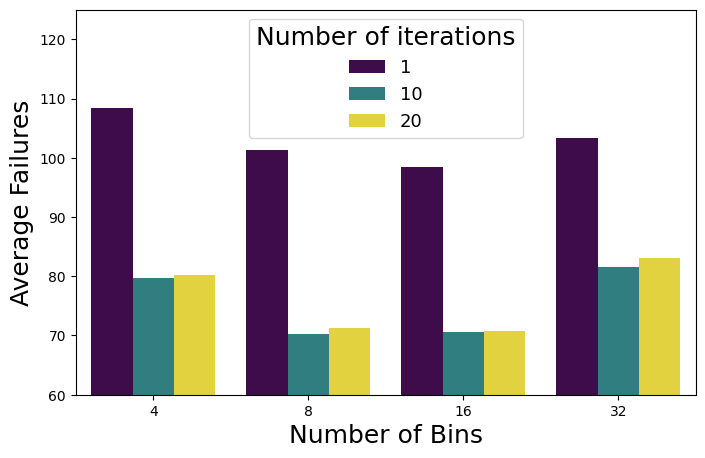

In [7]:
nbins_groups = df.groupby("nbins").agg({
    "failures": "mean",
    "fps": "mean"
})

niters_groups = df.groupby("n_iters").agg({
    "failures": "mean",
    "fps": "mean"
})

import matplotlib.pyplot as plt
import seaborn as sns

# Merge the data for plotting
plot_data = df.groupby(["nbins", "n_iters"]).agg({"failures": "mean", "fps": "mean"}).reset_index()

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x="nbins", 
    y="failures", 
    hue="n_iters", 
    data=plot_data, 
    palette="viridis"
)
plt.ylim(60,125)
# Set labels and title
plt.xlabel("Number of Bins", fontsize=18)
plt.ylabel("Average Failures", fontsize=18)
plt.legend(title="Number of iterations", title_fontsize=18, fontsize=13)

# Show the plot
plt.savefig("report/figures/nbins_niters.png")


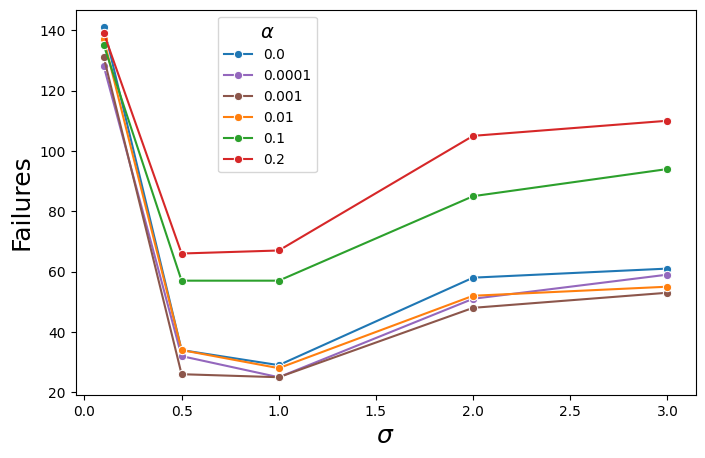

In [23]:
df = pd.read_csv("parameter_tuning.csv")
df_sigmas = df[df["nbins"] == 16]
df_sigmas = df_sigmas[df_sigmas["n_iters"] == 20]

custom_palette = {
    0.0: "#1f77b4",  # Blue
    0.0001: "#9467bd", # Purple
    0.001: "#8c564b",  # Brown
    0.01: "#ff7f0e",  # Orange
    0.10: "#2ca02c",  # Green
    0.20: "#d62728",  # Red
}


plt.figure(figsize=(8, 5))
sns.lineplot(data=df_sigmas, x="sigma", y="failures", hue="alpha", marker="o", palette=custom_palette)

# Set plot labels and title
plt.xlabel(r'$\sigma$', fontsize=18)
plt.ylabel("Failures", fontsize=18)
plt.legend(title=r'$\alpha$', fontsize=10, title_fontsize=14 , bbox_to_anchor=(0.4, 1))
plt.savefig("report/figures/sigma_alpha.png")

In [24]:
import time
import os
import cv2
import pandas as pd

from sequence_utils import VOTSequence
#from ncc_tracker_example import NCCTracker, NCCParams
from ms_tracker import MeanShiftTracker, MSParams


# set the path to directory where you have the sequences
dataset_path = 'C:\\Users\\marko\\Desktop\\Computer_vision\\Advanced-methods-in-computer-vision-assignments\\Mean-Shift-tracking\\vot2014' # TODO: set to the dataet path on your disk
filenames = os.listdir(dataset_path)
filenames.remove("list.txt")

df = pd.DataFrame(columns=["color_space", "bg_ratio", "alpha", "failures", "fps"])

# Try all possible combinations of parameters
for color_space in [ "RGB", "LAB", "HSV", "YCrCb","BGR"]:
    for bg_ratio in [1.5,2, 3, 4,5]:

        total_errors = 0
        avg_fps = 0
        for sequence in filenames:
            #print(sequence)
            # visualization and setup parameters
            win_name = 'Tracking window'
            reinitialize = True
            show_gt = False
            video_delay = 15
            font = cv2.FONT_HERSHEY_PLAIN

            # create sequence object
            sequence = VOTSequence(dataset_path, sequence)
            init_frame = 0
            n_failures = 0
            parameters = MSParams(nbins=16, sigma=1, n_iters=20, alpha=0.001, 
                                    background_size_ratio=bg_ratio, color_space=color_space)  # Example fixed params, adjust as needed
            tracker = MeanShiftTracker(parameters)
            time_all = 0

            # initialize visualization window
            #sequence.initialize_window(win_name)
            # tracking loop - goes over all frames in the video sequence
            frame_idx = 0
            while frame_idx < sequence.length():
                img = cv2.imread(sequence.frame(frame_idx))
                # initialize or track
                if frame_idx == init_frame:
                    # initialize tracker (at the beginning of the sequence or after tracking failure)
                    #print(sequence.get_annotation(frame_idx, type='rectangle'))
                    t_ = time.time()
                    tracker.initialize(img, sequence.get_annotation(frame_idx, type='rectangle'))
                    time_all += time.time() - t_
                    predicted_bbox = sequence.get_annotation(frame_idx, type='rectangle')
                else:
                    # track on current frame - predict bounding box
                    t_ = time.time()
                    predicted_bbox = tracker.track(img)
                    time_all += time.time() - t_

                # calculate overlap (needed to determine failure of a tracker)
                gt_bb = sequence.get_annotation(frame_idx, type='rectangle')
                o = sequence.overlap(predicted_bbox, gt_bb)


                if o > 0 or not reinitialize:
                    # increase frame counter by 1
                    frame_idx += 1
                else:
                    # increase frame counter by 5 and set re-initialization to the next frame
                    frame_idx += 5
                    init_frame = frame_idx
                    n_failures += 1

            avg_fps += (sequence.length() / (time_all + 1e-10))
            total_errors += n_failures

        # Average FPS over the dataset
        avg_fps /= len(filenames)

        # Store results in the dataframe
        temp_df = pd.DataFrame([[color_space, bg_ratio, alpha, total_errors, avg_fps]],
                                columns=["color_space", "bg_ratio", "alpha", "failures", "fps"])
        df = pd.concat([df, temp_df], ignore_index=True)

        print(f"Parameters: {color_space}, {bg_ratio}, {alpha}")
        print(f"Total errors on the dataset: {total_errors}, Avg FPS: {avg_fps}")

# Save the results to a CSV file
df.to_csv("parameter_tuning2.csv", index=False)

C:\Users\marko\AppData\Local\Temp\ipykernel_23148\2368898548.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)


Parameters: RGB, 1.5, 0.2
Total errors on the dataset: 22, Avg FPS: 1575.297069590194
Parameters: RGB, 2, 0.2
Total errors on the dataset: 19, Avg FPS: 1725.2661848011287
Parameters: RGB, 3, 0.2
Total errors on the dataset: 19, Avg FPS: 1612.0632599043267
Parameters: RGB, 4, 0.2
Total errors on the dataset: 23, Avg FPS: 1572.9851917286994
Parameters: RGB, 5, 0.2
Total errors on the dataset: 21, Avg FPS: 1588.46812847084
Parameters: LAB, 1.5, 0.2
Total errors on the dataset: 21, Avg FPS: 976.9552270376328
Parameters: LAB, 2, 0.2
Total errors on the dataset: 25, Avg FPS: 1009.7434020389542
Parameters: LAB, 3, 0.2
Total errors on the dataset: 29, Avg FPS: 1052.1697362602308
Parameters: LAB, 4, 0.2
Total errors on the dataset: 27, Avg FPS: 1071.570215991405
Parameters: LAB, 5, 0.2
Total errors on the dataset: 29, Avg FPS: 1076.5333378742923
Parameters: HSV, 1.5, 0.2
Total errors on the dataset: 16, Avg FPS: 1305.8798866954771
Parameters: HSV, 2, 0.2
Total errors on the dataset: 16, Avg FPS

In [28]:
df = pd.read_csv("parameter_tuning2.csv")
# Agregate by the bg_ration and alpha 
df.sort_values(by="failures")

,color_space,bg_ratio,alpha,failures,fps
10,HSV,1.5,0.2,16,1305.879887
12,HSV,3.0,0.2,16,1383.999904
11,HSV,2.0,0.2,16,1415.287740
13,HSV,4.0,0.2,17,1273.375857
14,HSV,5.0,0.2,18,1351.096312
1,RGB,2.0,0.2,19,1725.266185
2,RGB,3.0,0.2,19,1612.063260
22,BGR,3.0,0.2,19,1844.600208
21,BGR,2.0,0.2,19,1855.137826
24,BGR,5.0,0.2,21,1761.724328
